 ## Niyaz Gubaidullin

## Task 1: Exploratory Data Analysis (EDA) and Preprocessing (25 points)

## 1. Load the Data
- **Read `opsd_raw.csv` into a DataFrame.** Identify the relevant columns.
- **Manually confirm** which columns are for Denmark’s power load and productions by referencing `README.md`.

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
df = pd.read_csv('opsd_raw.csv')
required_columns = [
    'utc_timestamp',
    'DK_load_actual_entsoe_transparency',
    'DK_wind_generation_actual',
    'DK_solar_generation_actual'
]
df = df[required_columns]



## 2. Data Inspection
- Print the shape (rows × columns) of the raw data and the first few lines.
- Check for missing values (NaNs). Decide how you’ll handle them (drop rows,
fill forward, etc.).

In [5]:
print("=== Data Inspection ===")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())
df = df.dropna()

=== Data Inspection ===
Shape: (50400, 4)

First 5 rows:
               utc_timestamp  DK_load_actual_entsoe_transparency  \
0  2015-01-01 00:00:00+00:00                                 NaN   
1  2015-01-01 01:00:00+00:00                             3100.02   
2  2015-01-01 02:00:00+00:00                             2980.39   
3  2015-01-01 03:00:00+00:00                             2933.49   
4  2015-01-01 04:00:00+00:00                             2941.54   

   DK_wind_generation_actual  DK_solar_generation_actual  
0                        NaN                         NaN  
1                    2357.33                         NaN  
2                    2387.35                         NaN  
3                    2594.47                         NaN  
4                    3092.01                        0.01  

Missing values:
utc_timestamp                          0
DK_load_actual_entsoe_transparency     2
DK_wind_generation_actual              2
DK_solar_generation_actual            11

We can see that we have only **15 nil values** over **50,000 lines**. We can just remove them.

### Missing values:
- `utc_timestamp`: **0** missing values
- `DK_load_actual_entsoe_transparency`: **2** missing values
- `DK_wind_generation_actual`: **2** missing values
- `DK_solar_generation_actual`: **11** missing values


## 3. Form 24-Hour Arrays and Label Seasons.
- Convert the hourly data into daily slices of length 24.
- Ensure each daily record lines up with a single date (e.g., from midnight to
midnight).
- Show at least 5 sample arrays to confirm correctness.

In [9]:
##function to get season by date
def get_season(date):
    month = date.month
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'


df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df = df.sort_values('utc_timestamp')
df['date'] = df['utc_timestamp'].dt.date
df['season'] = df['utc_timestamp'].apply(get_season)

daily_data = []
for date, group in df.groupby('date'):
    if len(group) == 24:  # we only add full days
        daily_data.append({
            'date': date,
            'season': group['season'].iloc[0],
            'load_24h': group['DK_load_actual_entsoe_transparency'].values,
            'wind_24h': group['DK_wind_generation_actual'].values,
            'solar_24h': group['DK_solar_generation_actual'].values
        })

daily_df = pd.DataFrame(daily_data)
print("\n=== 5 Sample Days ===")
for i in range(5):  ##print first 5 days
    print(f"\nDate: {daily_df['date'].iloc[i]}, Season: {daily_df['season'].iloc[i]}")
    print(f"Load (first 5h): {daily_df['load_24h'].iloc[i]}")
    print(f"Wind (first 5h): {daily_df['wind_24h'].iloc[i]}")
    print(f"Solar (first 5h): {daily_df['solar_24h'].iloc[i]}")

print("\n=== Season Distribution ===")
print(daily_df['season'].value_counts())

##seson distribution:
# === Season Distribution ===
# season
# spring    552
# summer    552
# winter    510
# autumn    484
# Name: count, dtype: int64




=== 5 Sample Days ===

Date: 2015-01-02, Season: winter
Load (first 5h): [2996.22 2942.88 2944.18 3019.46 3104.17 3523.94 3868.58 4190.57 4337.33
 4515.6  4523.41 4474.24 4449.32 4396.41 4429.72 4741.13 5178.7  5091.42
 4725.76 4319.18 4131.82 3823.52 3530.62 3391.71]
Wind (first 5h): [3231.6  3212.27 3188.93 3167.6  3425.92 4297.12 4377.07 4389.64 4356.1
 4314.2  4284.06 4216.16 4239.82 4243.88 4208.41 4193.58 4223.47 4247.63
 4187.39 4050.   4176.21 4149.19 3947.79 4018.59]
Solar (first 5h): [0.000e+00 0.000e+00 0.000e+00 1.000e-02 1.000e-02 1.000e-02 1.000e-02
 6.000e-02 4.760e+00 2.904e+01 7.030e+01 7.766e+01 6.874e+01 3.544e+01
 6.910e+00 8.000e-02 1.000e-02 1.000e-02 1.000e-02 1.000e-02 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]

Date: 2015-01-03, Season: winter
Load (first 5h): [3277.54 3116.86 3041.39 3015.66 3078.47 3322.07 3636.03 3888.58 4062.27
 4177.13 4136.56 4073.81 4048.1  3986.69 3967.88 4337.85 4825.59 4751.57
 4325.66 4048.36 3792.96 3570.88 3377.74 3186.15]
Wind (fi

## 5. Train-test split.
- Split the daily records into train (70%), validation (15%), and test
(15%) sets.

In [10]:
train_df, temp_df = train_test_split(daily_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

## 6. Data scaling.
- Apply one of the standardisation (or scaling) methods you've learnt on
the IML course on every feature column. Avoid data leakage when fit a scaler.

In [12]:
def scale_data(df, scalers, fit=False):
    scaled = df.copy()
    for feature, scaler in scalers.items():
        data = np.vstack(scaled[f'{feature}_24h'])

        if fit:
            ## we train scaler with train data
            scaled_data = scaler.fit_transform(data)
        else:
            ## here we just scale data, no train
            scaled_data = scaler.transform(data)
        scaled[f'{feature}_24h'] = [row.tolist() for row in scaled_data]
    return scaled


features = ['load_24h', 'wind_24h', 'solar_24h']
scaler = StandardScaler()
scalers = {
    'load': StandardScaler(),
    'wind': StandardScaler(),
    'solar': StandardScaler()
}
train_df_scaled = scale_data(train_df, scalers, fit=True)
val_df_scaled = scale_data(val_df, scalers)
test_df_scaled = scale_data(test_df, scalers)

## here we check results of scaling. Mean nust be 0 while std must be 1
for feature in ['load', 'wind', 'solar']:
    data = np.vstack(train_df_scaled[f'{feature}_24h'])
    print(f"{feature} - mean: {data.mean():.2f}, std: {data.std():.2f}")

load - mean: -0.00, std: 1.00
wind - mean: -0.00, std: 1.00
solar - mean: -0.00, std: 1.00


## 7. Brief Analysis
- Plot at least one example of a daily consumption profile for each season.
- Include 1–2 personal observations (e.g., “We see that winter consumption is
generally higher than summer.”). This helps ensure you’re truly analyzing the
data beyond a purely automated approach.

I will plot first day of each season after scaling data

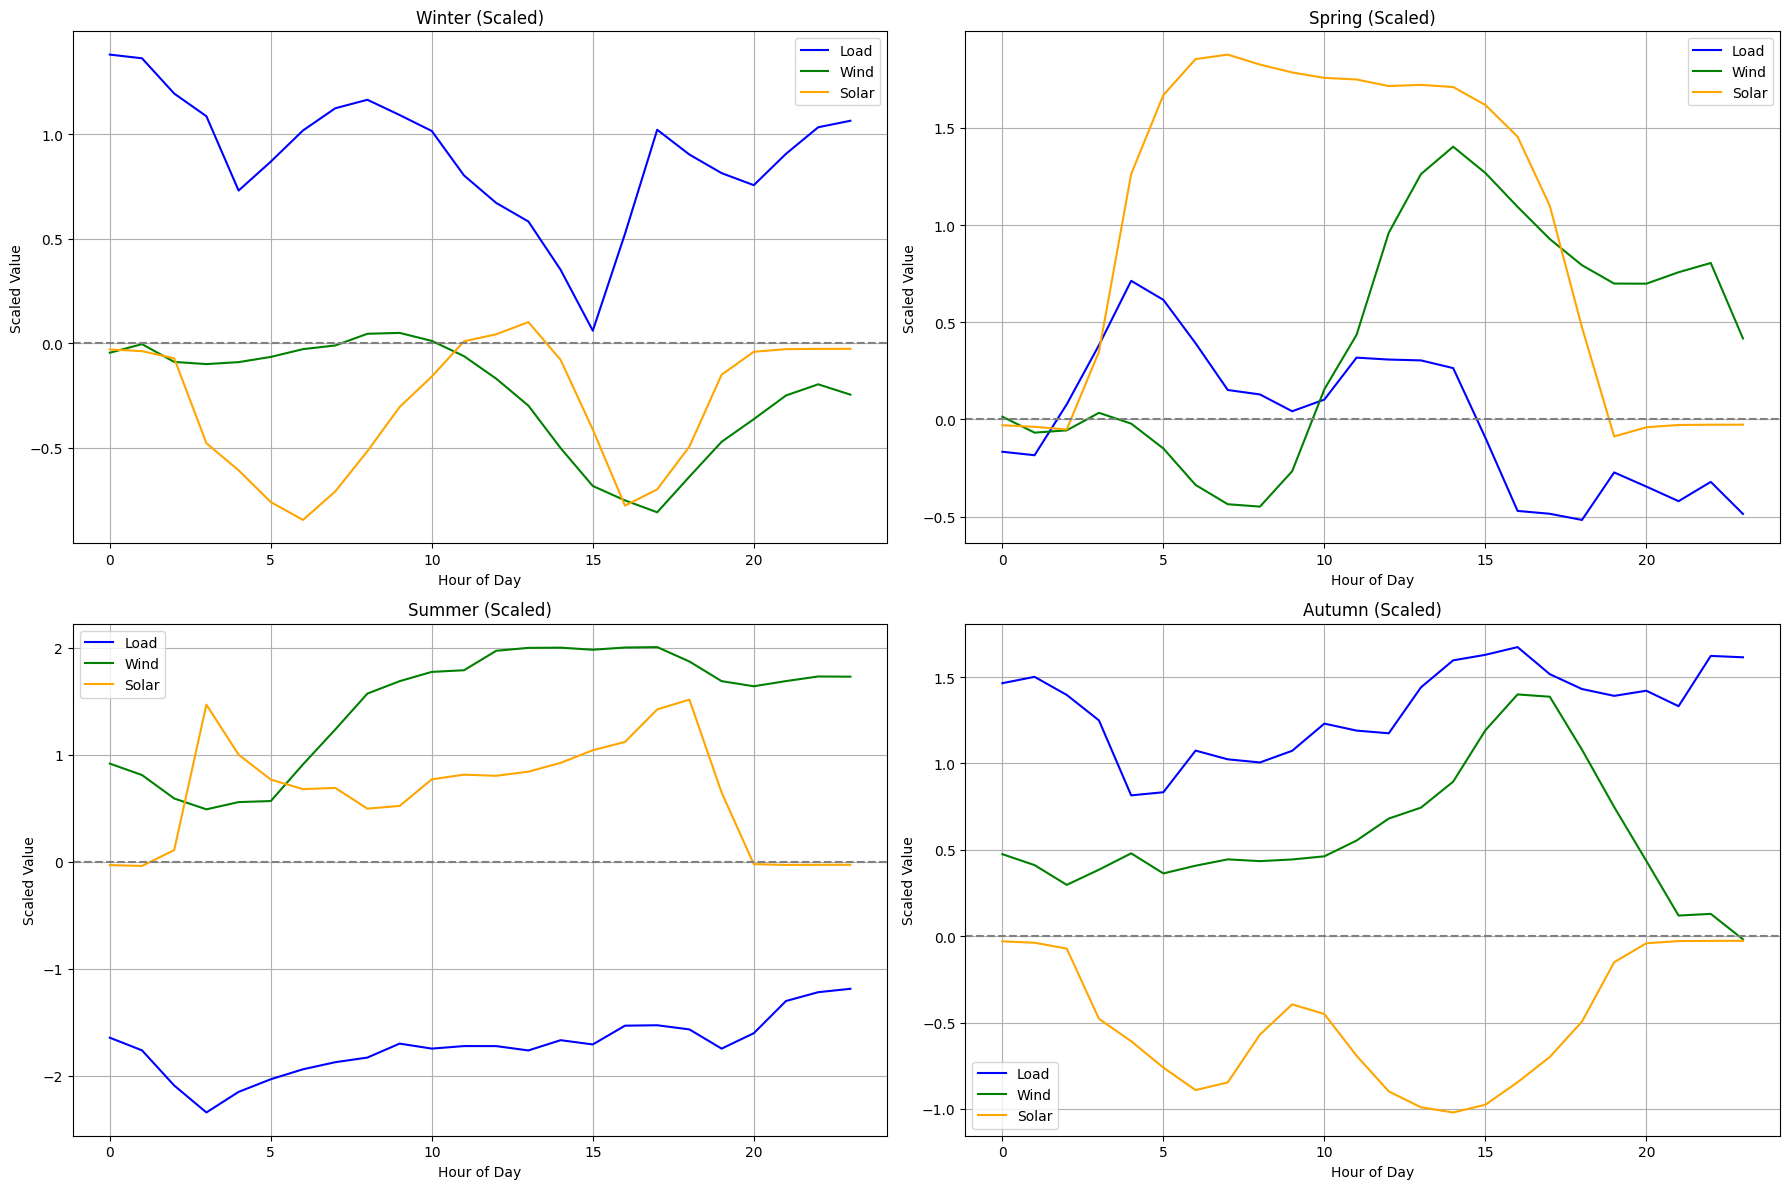

In [13]:
plt.figure(figsize=(18, 12))
seasons = ['winter', 'spring', 'summer', 'autumn']

for i, season in enumerate(seasons, 1):
    # take first day of each season
    season_data = train_df_scaled[train_df_scaled['season'] == season].iloc[0]

    plt.subplot(2, 2, i)

    # plot lines for load, solar and wind
    plt.plot(season_data['load_24h'], label='Load', color='blue')
    plt.plot(season_data['wind_24h'], label='Wind', color='green')
    plt.plot(season_data['solar_24h'], label='Solar', color='orange')

    plt.title(f'{season.capitalize()} (Scaled)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Scaled Value')
    plt.axhline(y=0, color='gray', linestyle='--')  # Нулевая линия
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

- We may notice that energy consumption is much higher in winter than in summer.
- There is also more solar energy generated in summer than in winter.

# Task 2: Baseline MLP (Fully-Connected Network) (15 points)

### 1. Implement an MLP in PyTorch with at least:
- One hidden layer (e.g., 32–128 neurons).
- Non-linear activation (e.g., ReLU).

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


class MLP(nn.Module):
    #These parameters provided an optimal balance between the learning rate and the quality of the model for this task. hidden_size=64 and Learning Rate (0.001):
    def __init__(self, input_size=72, hidden_size=64, output_size=4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### 2. Input Representation
- Flatten the 24-hour sequence into a 24-dimensional vector.
- Normalize or standardize the inputs if needed.

In [16]:
def prepare_data(df):
    features = np.array([np.concatenate([day['load_24h'],
                                         day['wind_24h'],
                                         day['solar_24h']])
                         for day in df.to_dict('records')])
    season_to_idx = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}
    labels = np.array([season_to_idx[day['season']] for day in df.to_dict('records')])
    return torch.FloatTensor(features), torch.LongTensor(labels)

### 3. Train & Evaluate
- Show training curves for loss and accuracy.
- Evaluate on both validation and test sets, and report final accuracy.

In [17]:
## here we train model with 50 epochs and 32 batch_size

def train_model(train_df, val_df, epochs=50, batch_size=32):
    # prepare data
    X_train, y_train = prepare_data(train_df)
    X_val, y_val = prepare_data(val_df)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # create model
    model = MLP(input_size=72, hidden_size=64, output_size=4)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #save data for plot
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_acc = accuracy_score(y_val.numpy(), val_predicted.numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss.item())
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # print results of epochs
        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs


model, train_losses, val_losses, train_accs, val_accs = train_model(train_df_scaled, val_df_scaled, epochs=50)

Epoch 1/50: Train Loss: 1.0279, Val Loss: 0.8663, Train Acc: 0.5559, Val Acc: 0.6317
Epoch 2/50: Train Loss: 0.7998, Val Loss: 0.7387, Train Acc: 0.6683, Val Acc: 0.6857
Epoch 3/50: Train Loss: 0.7037, Val Loss: 0.6849, Train Acc: 0.7003, Val Acc: 0.7016
Epoch 4/50: Train Loss: 0.6528, Val Loss: 0.6474, Train Acc: 0.7268, Val Acc: 0.7175
Epoch 5/50: Train Loss: 0.6098, Val Loss: 0.6282, Train Acc: 0.7459, Val Acc: 0.7238
Epoch 6/50: Train Loss: 0.5807, Val Loss: 0.5955, Train Acc: 0.7514, Val Acc: 0.7460
Epoch 7/50: Train Loss: 0.5546, Val Loss: 0.5849, Train Acc: 0.7616, Val Acc: 0.7714
Epoch 8/50: Train Loss: 0.5369, Val Loss: 0.5550, Train Acc: 0.7691, Val Acc: 0.7524
Epoch 9/50: Train Loss: 0.5147, Val Loss: 0.5412, Train Acc: 0.7820, Val Acc: 0.7619
Epoch 10/50: Train Loss: 0.4983, Val Loss: 0.5580, Train Acc: 0.7956, Val Acc: 0.7746
Epoch 11/50: Train Loss: 0.4852, Val Loss: 0.5239, Train Acc: 0.7943, Val Acc: 0.7873
Epoch 12/50: Train Loss: 0.4660, Val Loss: 0.5235, Train Acc: 0

### Check accurancy on test data, print accuracy, final “test set” predictions and classification report

- we have test accuracy 0.8730
- Classification Report: to view it run code

In [24]:
def evaluate_model(model, test_df):
    X_test, y_test = prepare_data(test_df)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
    print(f'Test Accuracy: {accuracy:.4f}')

    print("\nTest Set Predictions:")
    print(predicted.numpy())

    print("\nClassification Report:")
    print(classification_report(y_test.numpy(), predicted.numpy(),
                                target_names=['winter', 'spring', 'summer', 'autumn']))
    return accuracy


evaluate_model(model, test_df_scaled)

Test Accuracy: 0.8730

Test Set Predictions:
[0 2 1 1 1 0 3 3 3 2 2 3 0 2 0 1 1 3 0 3 2 3 2 2 1 2 0 0 0 2 0 1 2 2 2 2 1
 1 2 0 0 2 3 2 1 1 3 3 1 0 0 0 1 0 3 2 2 3 1 0 3 1 0 2 2 2 1 2 1 0 0 2 0 1
 1 2 2 3 3 2 0 0 1 0 0 1 3 3 0 0 3 2 2 3 1 3 2 3 0 3 1 3 0 1 0 3 3 2 1 1 1
 3 0 1 2 2 3 0 3 0 3 1 3 2 0 0 3 3 3 2 2 3 0 2 1 0 3 1 2 0 0 2 3 2 1 2 3 2
 2 1 1 3 1 1 3 2 3 3 3 2 0 1 3 1 2 3 2 3 1 3 2 2 0 0 1 2 2 1 2 2 2 3 1 1 2
 3 3 3 3 0 0 2 3 0 1 1 3 2 3 2 1 2 3 0 2 2 1 3 1 1 1 2 2 2 0 0 2 0 3 3 1 0
 1 0 1 0 1 3 3 3 0 2 1 0 0 0 0 3 2 0 1 0 0 0 0 3 0 2 1 2 0 1 0 1 0 3 3 0 2
 0 3 2 1 2 0 0 3 1 2 3 2 3 2 3 1 2 3 2 0 0 2 1 0 2 3 3 0 0 3 2 3 2 0 3 3 2
 3 1 0 0 2 0 1 1 2 3 2 0 3 3 1 0 3 1 2]

Classification Report:
              precision    recall  f1-score   support

      winter       0.81      0.92      0.86        71
      spring       0.93      0.79      0.85        80
      summer       0.85      0.95      0.89        76
      autumn       0.91      0.85      0.88        88

    accuracy       

0.873015873015873

### Plots

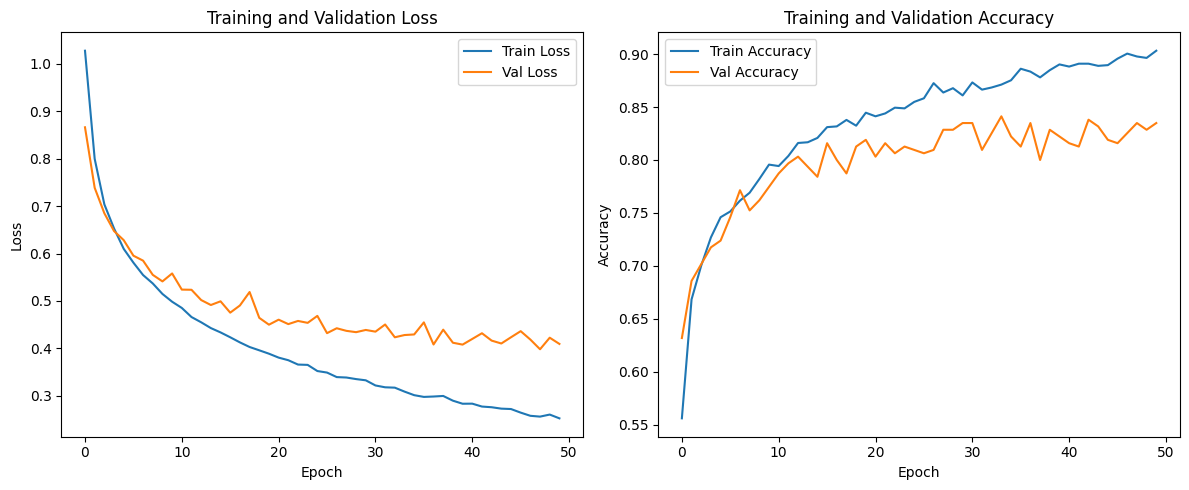

In [20]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, val_losses, train_accs, val_accs)

# Task 3: 1D-CNN on Raw Time-Series (20 points)

### 1. 1D Convolution Architecture
- Use PyTorch Conv1d layers to process 3-channels sequences of length 24.
- At least one convolutional layer, one pooling layer, and a final fully connected
layer for classification.

In [21]:
class CNN1D(nn.Module):
    def __init__(self, input_channels=3, seq_len=24, num_classes=4):
        super(CNN1D, self).__init__()

        # (batch_size, 3, 24) -> (batch_size, 32, 22)
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding='valid')
        self.relu = nn.ReLU()

        # (batch_size, 32, 22) -> (batch_size, 32, 11)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # (batch_size, 32 * 11) -> (batch_size, 64)
        self.fc1 = nn.Linear(32 * 11, 64)

        # (batch_size, 64) -> (batch_size, 4)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

def prepare_cnn_data(df):
    features = np.array([np.stack([day['load_24h'],
                                   day['wind_24h'],
                                   day['solar_24h']], axis=0)
                         for day in df.to_dict('records')])

    season_to_idx = {'winter': 0, 'spring': 1, 'summer': 2, 'autumn': 3}
    labels = np.array([season_to_idx[day['season']] for day in df.to_dict('records')])

    return torch.FloatTensor(features), torch.LongTensor(labels)

### Train and validate cnn

In [22]:
def train_cnn(train_df, val_df, epochs=50, batch_size=32):
    X_train, y_train = prepare_cnn_data(train_df)
    X_val, y_val = prepare_cnn_data(val_df)

    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = CNN1D(input_channels=3, seq_len=24, num_classes=4)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_acc = accuracy_score(y_val.numpy(), val_predicted.numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss.item())
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{epochs}: '
              f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss.item():.4f}, '
              f'Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return model, train_losses, val_losses, train_accs, val_accs

model_cnn, train_losses_cnn, val_losses_cnn, train_accs_cnn, val_accs_cnn = train_cnn(
        train_df_scaled, val_df_scaled, epochs=50)


Epoch 1/50: Train Loss: 1.0087, Val Loss: 0.7653, Train Acc: 0.5654, Val Acc: 0.6921
Epoch 2/50: Train Loss: 0.7067, Val Loss: 0.6566, Train Acc: 0.6975, Val Acc: 0.7397
Epoch 3/50: Train Loss: 0.6190, Val Loss: 0.6083, Train Acc: 0.7282, Val Acc: 0.7238
Epoch 4/50: Train Loss: 0.5750, Val Loss: 0.5900, Train Acc: 0.7609, Val Acc: 0.7714
Epoch 5/50: Train Loss: 0.5432, Val Loss: 0.5438, Train Acc: 0.7670, Val Acc: 0.7778
Epoch 6/50: Train Loss: 0.5139, Val Loss: 0.5243, Train Acc: 0.7834, Val Acc: 0.7937
Epoch 7/50: Train Loss: 0.4997, Val Loss: 0.5149, Train Acc: 0.8004, Val Acc: 0.7968
Epoch 8/50: Train Loss: 0.4641, Val Loss: 0.5054, Train Acc: 0.8086, Val Acc: 0.7937
Epoch 9/50: Train Loss: 0.4520, Val Loss: 0.4865, Train Acc: 0.8154, Val Acc: 0.8000
Epoch 10/50: Train Loss: 0.4552, Val Loss: 0.4742, Train Acc: 0.8106, Val Acc: 0.8159
Epoch 11/50: Train Loss: 0.4250, Val Loss: 0.4737, Train Acc: 0.8270, Val Acc: 0.7937
Epoch 12/50: Train Loss: 0.4115, Val Loss: 0.4471, Train Acc: 0

### CNN Test Accurancy, Test Set Predictions and Classification Report

In [23]:
def evaluate_cnn(model, test_df):
    X_test, y_test = prepare_cnn_data(test_df)
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

        accuracy = accuracy_score(y_test.numpy(), predicted.numpy())
        print(f'Test Accuracy: {accuracy:.4f}')

        print("\nTest Set Predictions:")
        print(predicted.numpy())

        print("\nClassification Report:")
        print(classification_report(y_test.numpy(), predicted.numpy(),
                                    target_names=['winter', 'spring', 'summer', 'autumn']))

    return

test_acc = evaluate_cnn(model_cnn, test_df_scaled)



Test Accuracy: 0.8889

Test Set Predictions:
[0 2 1 1 1 0 3 0 3 2 1 3 0 2 0 1 1 3 0 3 2 3 2 2 1 2 0 0 0 2 0 1 2 2 2 1 1
 1 2 0 0 1 3 2 1 1 3 2 1 0 0 0 1 3 3 2 2 3 1 1 3 1 1 2 2 1 1 2 1 0 0 1 1 1
 1 2 2 3 3 2 0 0 1 0 0 1 3 2 0 0 3 2 2 3 1 3 2 3 1 3 1 3 0 1 0 2 3 2 2 1 0
 3 0 1 2 2 3 0 3 0 3 2 3 2 3 0 3 3 3 2 2 3 0 3 1 0 3 1 2 1 0 2 3 2 1 3 3 2
 2 1 1 3 1 1 3 2 1 3 3 2 1 1 3 2 2 3 2 3 1 3 2 2 0 0 1 2 1 1 2 2 2 3 1 1 2
 3 3 3 3 0 0 2 3 0 1 1 3 2 3 2 1 2 3 0 2 2 1 3 1 1 1 2 2 2 0 0 2 0 3 3 1 0
 1 3 1 0 1 3 3 3 1 2 1 3 1 0 0 3 2 0 1 0 3 3 0 3 3 2 1 2 0 1 0 1 0 3 3 0 2
 0 3 2 1 2 0 0 3 1 2 3 2 3 2 3 1 2 3 2 3 0 2 1 0 2 3 3 0 0 3 2 3 2 1 3 3 2
 3 1 0 0 2 0 1 2 2 3 1 0 3 3 1 0 3 1 2]

Classification Report:
              precision    recall  f1-score   support

      winter       0.95      0.87      0.91        71
      spring       0.88      0.88      0.88        80
      summer       0.83      0.91      0.87        76
      autumn       0.91      0.90      0.90        88

    accuracy       

### MLP vs CNN

- CNN accuracy: 0.8889
- MLP accuracy: 0.8730